## TOC
* [Model RDM](#modelrdm-bullet)
* [Model comparison](#modelcompare-bullet)
    * [Functions](#functions-bullet)
    * [Bartra ROIs](#bartra)

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
import scipy.spatial.distance as sp_distance

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.input_data import NiftiMasker, NiftiSpheresMasker

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from nltools.mask import create_sphere

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Autosaving every 5 seconds


In [2]:
base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/1stLevel/'
out_root = '/home/rj299/scratch60/mdm_analysis/output/'
anat_mean = nib.load(os.path.join(out_root, 'imaging', 'all_sub_average.nii.gz'))

In [3]:
stims = {'01': 'Med_amb_0', '02': 'Med_amb_1', '03': 'Med_amb_2', '04': 'Med_amb_3',
         '05': 'Med_risk_0', '06': 'Med_risk_1', '07': 'Med_risk_2', '08': 'Med_risk_3', 
         '09': 'Mon_amb_0', '10': 'Mon_amb_1', '11': 'Mon_amb_2', '12': 'Mon_amb_3',
         '13': 'Mon_risk_0', '14': 'Mon_risk_1', '15': 'Mon_risk_2', '16': 'Mon_risk_3'}

stim_num = len(stims)

subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 
            2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 
            2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]

In [4]:
# all rois' names
sub = 2654
roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
              allow_pickle = True)
roi_rdm = roi_rdm_obj.item()
roi_names_all = list(roi_rdm.keys())

print('All names of ROIs:')
for roi_name in roi_names_all:
    print(roi_name)

All names of ROIs:
vmpfc
vstr
med_mon_1
med_mon_2
med_mon_3
gilaie_rppc
zhang_val_lppc
zhang_val_lofc
zhang_val_rofc
zhang_val_lingual
zhang_sal_acc
zhang_sal_lprecentral
zhang_sal_lcaudate
zhang_sal_rcaudate
zhang_sal_linsula
zhang_sal_rinsula
zhang_sal_lingual
levy_amb_striatum
levy_amb_mpfc
levy_amb_ppc
levy_amb_lamyg
levy_amb_sts
levy_risk_striatum
levy_risk_mpfc


## Model RDM <a class="anchor" id="modelrdm-bullet"></a>

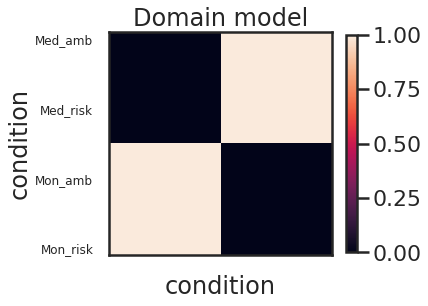

In [5]:
# Model RDM domain difference
mod_rdm_domain = np.ones([16,16])

med_id = list(range(8))
mon_id = list(range(8,16))

mon_mask = [(a,b) for a in mon_id for b in mon_id]
med_mask = [(a,b) for a in med_id for b in med_id]

for mon_mask_idx in mon_mask:  
    mod_rdm_domain[mon_mask_idx] = 0
for med_mask_idx in med_mask:  
    mod_rdm_domain[med_mask_idx] = 0

stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 12}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_domain)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Domain model') 
ax.set_ylabel('condition')
ax.set_xlabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)

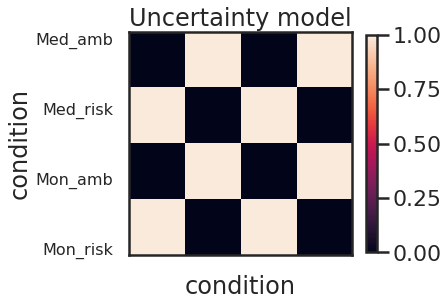

In [6]:
# Model RDM risk/ambig difference
mod_rdm_uncert = np.ones([16,16])

risk_id = [0,1,2,3,8,9,10,11]
amb_id = [4,5,6,7,12,13,14,15]

amb_mask = [(a,b) for a in risk_id for b in risk_id]
risk_mask = [(a,b) for a in amb_id for b in amb_id]

for risk_mask_idx in risk_mask:  
    mod_rdm_uncert[risk_mask_idx] = 0
for amb_mask_idx in amb_mask:  
    mod_rdm_uncert[amb_mask_idx] = 0

stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 16}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_uncert)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Uncertainty model') 
ax.set_xlabel('condition')
ax.set_ylabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)

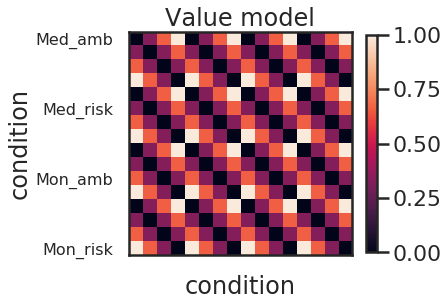

In [7]:
# Model RDM value (outcome magnitude) difference
mod_rdm_val = np.ones([16,16])

level = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3])

for i in range(len(level)):
    for j in range(len(level)):
        mod_rdm_val[i, j] = abs(level[i] - level[j])/3
        
stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 16}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_val)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Value model') 
ax.set_xlabel('condition')
ax.set_ylabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)        

In [11]:
# value model based on each individual's rating
def rating_model(sub_id, ratings):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-11-c55563e7f2bf>, line 3)

## Model comparison <a class="anchor" id="modelcompare-bullet"></a>

In [17]:
def half_matrix(matrix):
    ''' Take half of the correlation matrix, excluding diagnoal
    Input:
        matrix
    
    Output:
        half_matrix: matrix with the upper half and diagnal equals to nan
        vector: vector of the half matrix, without nan
    '''
    import copy
    
    half_matrix = copy.deepcopy(matrix)
    
    vector = []
    for i in range(half_matrix.shape[0]):
        for j in range(half_matrix.shape[1]):
            if i-j <= 0:
                half_matrix[i,j] = np.nan
            else:
                vector.append(half_matrix[i,j])
    
    return half_matrix, np.array(vector)

In [10]:
# all models to compare
mod_rdm = {'domain': mod_rdm_domain, 'uncertainty': mod_rdm_uncert, 
          'value': mod_rdm_val}

# vectorize

# mod_rdm_vector = {mod_name: 
#                   mod_rdm[mod_name].reshape(mod_rdm[mod_name].shape[0]*mod_rdm[mod_name].shape[1],)
#                   for mod_name in list(mod_rdm.keys())} 

mod_rdm_vector = {}
for mod_name in mod_rdm.keys():
    _, mod_rdm_vector[mod_name] = half_matrix(mod_rdm[mod_name])

### Functions to compare model and plot based on rois chosen <a class="anchor" id="functions-bullet"></a>

In [45]:
# calculate spearman correlation between rdm and model rdm
# for each model, each roi, each subject

def compare_with_model(subjects, roi_names, mod_rdm_vector):
    
    mod_names = list(mod_rdm_vector.keys())
    
    spearman_r = {mod_name: {} for mod_name in mod_names} # each model is an entry in this dictionary
    spearman_p = {mod_name: {} for mod_name in mod_names}
        
#     spearman_r = {'domain': {}, 'uncertainty': {}, 'value': {}}
#     spearman_p = {'domain': {}, 'uncertainty': {}, 'value': {}}

    for (mod_idx, mod_name) in enumerate(mod_names):
        
        # each roi is an entry in the dictionary
        spearman_r_mod = {roi_name: [] for roi_name in roi_names} # spearman's rho
        spearman_p_mod = {roi_name: [] for roi_name in roi_names} # p values

    #     spearman_r_mod = {'vmpfc': [], 'vstr': []}
    #     spearman_p_mod = {'vmpfc': [], 'vstr': []}

        for sub in subjects:
            roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
                   allow_pickle = True)

            # get dictionary type
            roi_rdm = roi_rdm_obj.item()

    #         roi_names = list(roi_rdm.keys())

            for (roi_idx, roi_name) in enumerate(roi_names):
                # spearman bween model rdm and individual rdm, using only half of matrix
                rdm_half, rdm_vector = half_matrix(roi_rdm[roi_name])

                rho, pvalue = stats.spearmanr(rdm_vector, mod_rdm_vector[mod_name])

                spearman_r_mod[roi_name].append(rho)
                spearman_p_mod[roi_name].append(pvalue)

        spearman_r[mod_name] = spearman_r_mod
        spearman_p[mod_name] = spearman_p_mod
        
    return spearman_r, spearman_p

In [46]:
# plot spearman r distribution
def plot_r_hist(r):
    
    mod_names = list(r.keys())
    roi_names = list(r[mod_names[0]].keys())
    
    for (mod_idx, mod_name) in enumerate(mod_names):

        f, ax = plt.subplots(1, len(roi_names), figsize = (15,7))
        for (roi_idx, roi_name) in enumerate(roi_names):
            # plot distribution
            ax[roi_idx].hist(r[mod_name][roi_name], bins = 15)
            # plot median
            median = np.median(r[mod_name][roi_name])
            ax[roi_idx].vlines(median, ymin=0, ymax=ax[roi_idx].get_ylim()[1], 
                               colors = 'r', linestyles = 'dashed')
            ax[roi_idx].legend(['median = %s' %round(median,3)], fontsize = 15)
            ax[roi_idx].set_title('Spearman r, '+mod_name+', '+roi_name)

In [61]:
# permutation test

# for each iteration (iter_num), select perm_num subjects, calculate median
# each permutation: calculate spearman correlation between rdm and model rdm
# do this for each model, each roi

def permutation_test(subjects, roi_names, mod_rdm_vector,
                    iter_num = 1000, perm_num = 100):
    
#     iter_num number of iteration
#     perm_num number of subjects (permutation)
    
    mod_names = list(mod_rdm_vector.keys())
    
    r_perm = {mod_name: {} for mod_name in mod_names}

    # each model
    for (mod_idx, mod_name) in enumerate(mod_names):

        r_perm_mod = {roi_name: [] for roi_name in roi_names}

        # each ROI
        for (roi_idx, roi_name) in enumerate(roi_names):

            for iter_idx in range(iter_num): 

                rho_perm = []

                for perm_idx in range(perm_num):
                    # randomly select a subject
                    sub = np.random.choice(subjects)
                    roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
                                          allow_pickle = True)

                    # get dictionary type
                    roi_rdm = roi_rdm_obj.item()

                    rdm_perm = roi_rdm[roi_name]

                    # shuffle columns
                    np.random.shuffle(rdm_perm)

    #                 # permute columns of matrix
    #                 columns = list(range(roi_rdm[roi_name].shape(0)))

    #                 columns_perm = np.random.permutation(columns)

    #                 rdm_perm = np.argsort(columns_perm)

                    # spearman bween model rdm and individual rdm, half matrix
                    _, rdm_vector_perm = half_matrix(rdm_perm)

    #                 rdm_vector_perm = np.random.permutation(rdm_vector)
                    rho_i, pvalue_i = stats.spearmanr(rdm_vector_perm, mod_rdm_vector[mod_name])

                    rho_perm.append(rho_i)

                r_perm_mod[roi_name].append(np.median(rho_perm))
                
                print('Model %s, ROI %s, iteration %s finished' %(mod_name, roi_name, iter_idx+1))

        r_perm[mod_name] = r_perm_mod
        
    return r_perm

In [62]:
# plot permutation null distribution
def plot_permutation_null(r_perm, sig_level = 0.05):
    
#     sig_level = 0.05
    mod_names = list(r_perm.keys())
    roi_names = list(r_perm[mod_names[0]].keys())

    for (mod_idx, mod_name) in enumerate(mod_names):

        f, ax = plt.subplots(1, len(roi_names), figsize = (15,7))
        for (roi_idx, roi_name) in enumerate(roi_names):
            # plot distribution
            ax[roi_idx].hist(r_perm[mod_name][roi_name], bins = 15)

            # plot critical value
            n_iter = len(r_perm[mod_name][roi_name])
            # two-tailed
            critical_idx = int(n_iter * (1-sig_level/2))
            r_sorted = np.sort(r_perm[mod_name][roi_name])
            critical = r_sorted[critical_idx]
            ax[roi_idx].vlines(critical, ymin=0, ymax=ax[roi_idx].get_ylim()[1], 
                               colors = 'r', linestyles = 'dashed')
            ax[roi_idx].legend(['critical = %s' %round(critical,3)], 
                               fontsize = 15,
                              loc = 'upper left')

            ax[roi_idx].set_title('Spearman r perm, '+mod_name+', '+roi_name)    

### Bartra ROIs <a class="anchor" id="bartra"></a>

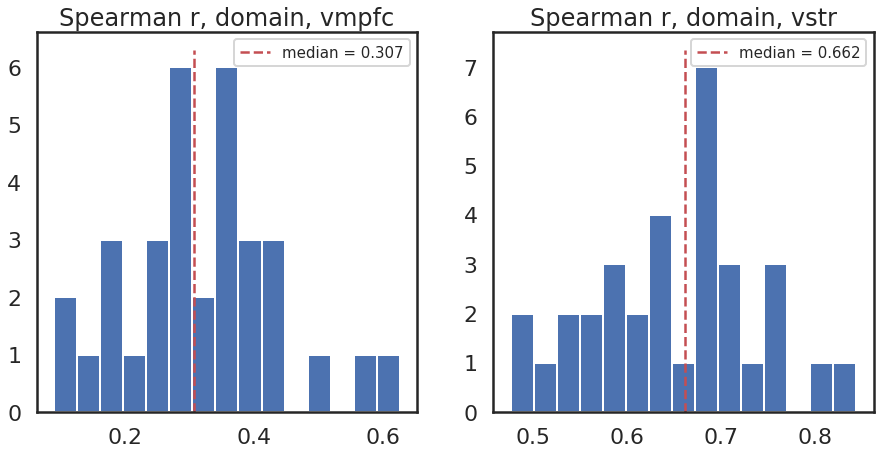

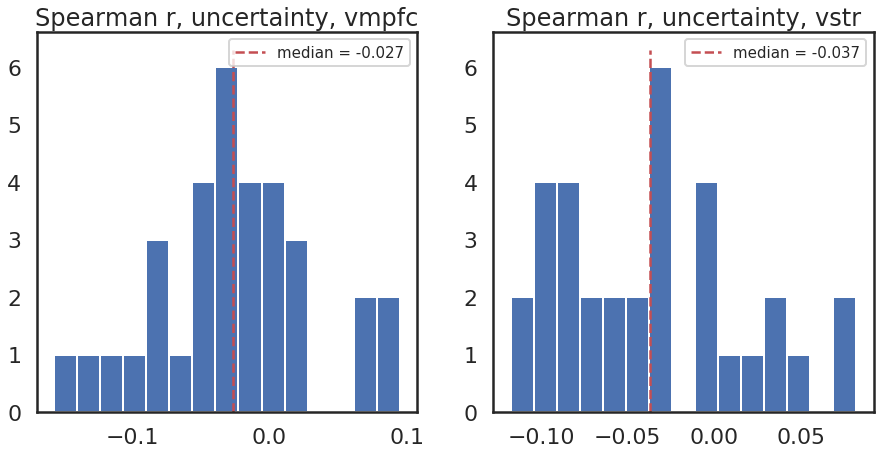

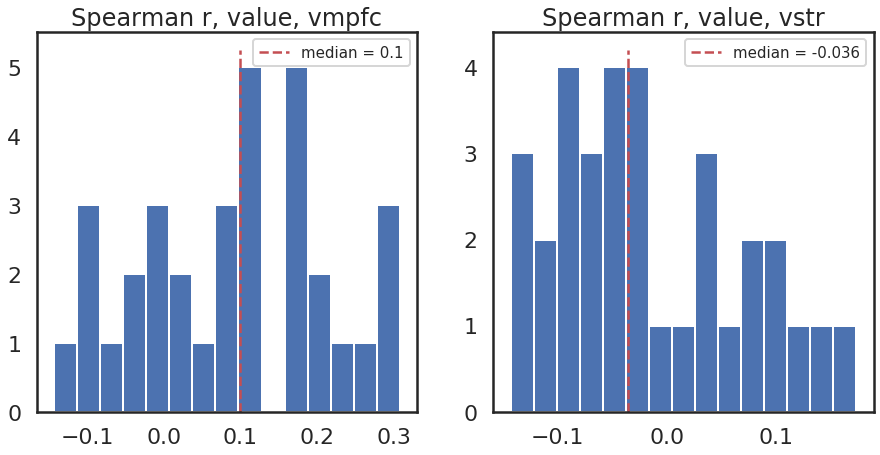

In [47]:
roi_names = ['vmpfc', 'vstr']

# plot correlation with model
spearman_r, spearman_p = compare_with_model(subjects, roi_names, mod_rdm_vector)

plot_r_hist(spearman_r)

In [68]:
# plot null distribution from permutation 
spearman_r_perm = permutation_test(subjects, roi_names, mod_rdm_vector,
#                                   iter_num = 200, perm_num = 50 # default: 1000, 100
                                  )

# save permutation results into somewhere

Model domain, ROI vmpfc, iteration 1 finished
Model domain, ROI vmpfc, iteration 2 finished
Model domain, ROI vmpfc, iteration 3 finished
Model domain, ROI vmpfc, iteration 4 finished
Model domain, ROI vmpfc, iteration 5 finished
Model domain, ROI vmpfc, iteration 6 finished
Model domain, ROI vmpfc, iteration 7 finished
Model domain, ROI vmpfc, iteration 8 finished
Model domain, ROI vmpfc, iteration 9 finished
Model domain, ROI vmpfc, iteration 10 finished
Model domain, ROI vmpfc, iteration 11 finished
Model domain, ROI vmpfc, iteration 12 finished
Model domain, ROI vmpfc, iteration 13 finished
Model domain, ROI vmpfc, iteration 14 finished
Model domain, ROI vmpfc, iteration 15 finished
Model domain, ROI vmpfc, iteration 16 finished
Model domain, ROI vmpfc, iteration 17 finished
Model domain, ROI vmpfc, iteration 18 finished
Model domain, ROI vmpfc, iteration 19 finished
Model domain, ROI vmpfc, iteration 20 finished
Model domain, ROI vmpfc, iteration 21 finished
Model domain, ROI vmpf

Model domain, ROI vmpfc, iteration 177 finished
Model domain, ROI vmpfc, iteration 178 finished
Model domain, ROI vmpfc, iteration 179 finished
Model domain, ROI vmpfc, iteration 180 finished
Model domain, ROI vmpfc, iteration 181 finished
Model domain, ROI vmpfc, iteration 182 finished
Model domain, ROI vmpfc, iteration 183 finished
Model domain, ROI vmpfc, iteration 184 finished
Model domain, ROI vmpfc, iteration 185 finished
Model domain, ROI vmpfc, iteration 186 finished
Model domain, ROI vmpfc, iteration 187 finished
Model domain, ROI vmpfc, iteration 188 finished
Model domain, ROI vmpfc, iteration 189 finished
Model domain, ROI vmpfc, iteration 190 finished
Model domain, ROI vmpfc, iteration 191 finished
Model domain, ROI vmpfc, iteration 192 finished
Model domain, ROI vmpfc, iteration 193 finished
Model domain, ROI vmpfc, iteration 194 finished
Model domain, ROI vmpfc, iteration 195 finished
Model domain, ROI vmpfc, iteration 196 finished
Model domain, ROI vmpfc, iteration 197 f

Model domain, ROI vmpfc, iteration 356 finished
Model domain, ROI vmpfc, iteration 357 finished
Model domain, ROI vmpfc, iteration 358 finished
Model domain, ROI vmpfc, iteration 359 finished
Model domain, ROI vmpfc, iteration 360 finished
Model domain, ROI vmpfc, iteration 361 finished
Model domain, ROI vmpfc, iteration 362 finished
Model domain, ROI vmpfc, iteration 363 finished
Model domain, ROI vmpfc, iteration 364 finished
Model domain, ROI vmpfc, iteration 365 finished
Model domain, ROI vmpfc, iteration 366 finished
Model domain, ROI vmpfc, iteration 367 finished
Model domain, ROI vmpfc, iteration 368 finished
Model domain, ROI vmpfc, iteration 369 finished
Model domain, ROI vmpfc, iteration 370 finished
Model domain, ROI vmpfc, iteration 371 finished
Model domain, ROI vmpfc, iteration 372 finished
Model domain, ROI vmpfc, iteration 373 finished
Model domain, ROI vmpfc, iteration 374 finished
Model domain, ROI vmpfc, iteration 375 finished
Model domain, ROI vmpfc, iteration 376 f

Model domain, ROI vmpfc, iteration 538 finished
Model domain, ROI vmpfc, iteration 539 finished
Model domain, ROI vmpfc, iteration 540 finished
Model domain, ROI vmpfc, iteration 541 finished
Model domain, ROI vmpfc, iteration 542 finished
Model domain, ROI vmpfc, iteration 543 finished
Model domain, ROI vmpfc, iteration 544 finished
Model domain, ROI vmpfc, iteration 545 finished
Model domain, ROI vmpfc, iteration 546 finished
Model domain, ROI vmpfc, iteration 547 finished
Model domain, ROI vmpfc, iteration 548 finished
Model domain, ROI vmpfc, iteration 549 finished
Model domain, ROI vmpfc, iteration 550 finished
Model domain, ROI vmpfc, iteration 551 finished
Model domain, ROI vmpfc, iteration 552 finished
Model domain, ROI vmpfc, iteration 553 finished
Model domain, ROI vmpfc, iteration 554 finished
Model domain, ROI vmpfc, iteration 555 finished
Model domain, ROI vmpfc, iteration 556 finished
Model domain, ROI vmpfc, iteration 557 finished
Model domain, ROI vmpfc, iteration 558 f

Model domain, ROI vmpfc, iteration 719 finished
Model domain, ROI vmpfc, iteration 720 finished
Model domain, ROI vmpfc, iteration 721 finished
Model domain, ROI vmpfc, iteration 722 finished
Model domain, ROI vmpfc, iteration 723 finished
Model domain, ROI vmpfc, iteration 724 finished
Model domain, ROI vmpfc, iteration 725 finished
Model domain, ROI vmpfc, iteration 726 finished
Model domain, ROI vmpfc, iteration 727 finished
Model domain, ROI vmpfc, iteration 728 finished
Model domain, ROI vmpfc, iteration 729 finished
Model domain, ROI vmpfc, iteration 730 finished
Model domain, ROI vmpfc, iteration 731 finished
Model domain, ROI vmpfc, iteration 732 finished
Model domain, ROI vmpfc, iteration 733 finished
Model domain, ROI vmpfc, iteration 734 finished
Model domain, ROI vmpfc, iteration 735 finished
Model domain, ROI vmpfc, iteration 736 finished
Model domain, ROI vmpfc, iteration 737 finished
Model domain, ROI vmpfc, iteration 738 finished
Model domain, ROI vmpfc, iteration 739 f

Model domain, ROI vmpfc, iteration 896 finished
Model domain, ROI vmpfc, iteration 897 finished
Model domain, ROI vmpfc, iteration 898 finished
Model domain, ROI vmpfc, iteration 899 finished
Model domain, ROI vmpfc, iteration 900 finished
Model domain, ROI vmpfc, iteration 901 finished
Model domain, ROI vmpfc, iteration 902 finished
Model domain, ROI vmpfc, iteration 903 finished
Model domain, ROI vmpfc, iteration 904 finished
Model domain, ROI vmpfc, iteration 905 finished
Model domain, ROI vmpfc, iteration 906 finished
Model domain, ROI vmpfc, iteration 907 finished
Model domain, ROI vmpfc, iteration 908 finished
Model domain, ROI vmpfc, iteration 909 finished
Model domain, ROI vmpfc, iteration 910 finished
Model domain, ROI vmpfc, iteration 911 finished
Model domain, ROI vmpfc, iteration 912 finished
Model domain, ROI vmpfc, iteration 913 finished
Model domain, ROI vmpfc, iteration 914 finished
Model domain, ROI vmpfc, iteration 915 finished
Model domain, ROI vmpfc, iteration 916 f

Model domain, ROI vstr, iteration 82 finished
Model domain, ROI vstr, iteration 83 finished
Model domain, ROI vstr, iteration 84 finished
Model domain, ROI vstr, iteration 85 finished
Model domain, ROI vstr, iteration 86 finished
Model domain, ROI vstr, iteration 87 finished
Model domain, ROI vstr, iteration 88 finished
Model domain, ROI vstr, iteration 89 finished
Model domain, ROI vstr, iteration 90 finished
Model domain, ROI vstr, iteration 91 finished
Model domain, ROI vstr, iteration 92 finished
Model domain, ROI vstr, iteration 93 finished
Model domain, ROI vstr, iteration 94 finished
Model domain, ROI vstr, iteration 95 finished
Model domain, ROI vstr, iteration 96 finished
Model domain, ROI vstr, iteration 97 finished
Model domain, ROI vstr, iteration 98 finished
Model domain, ROI vstr, iteration 99 finished
Model domain, ROI vstr, iteration 100 finished
Model domain, ROI vstr, iteration 101 finished
Model domain, ROI vstr, iteration 102 finished
Model domain, ROI vstr, iterati

Model domain, ROI vstr, iteration 265 finished
Model domain, ROI vstr, iteration 266 finished
Model domain, ROI vstr, iteration 267 finished
Model domain, ROI vstr, iteration 268 finished
Model domain, ROI vstr, iteration 269 finished
Model domain, ROI vstr, iteration 270 finished
Model domain, ROI vstr, iteration 271 finished
Model domain, ROI vstr, iteration 272 finished
Model domain, ROI vstr, iteration 273 finished
Model domain, ROI vstr, iteration 274 finished
Model domain, ROI vstr, iteration 275 finished
Model domain, ROI vstr, iteration 276 finished
Model domain, ROI vstr, iteration 277 finished
Model domain, ROI vstr, iteration 278 finished
Model domain, ROI vstr, iteration 279 finished
Model domain, ROI vstr, iteration 280 finished
Model domain, ROI vstr, iteration 281 finished
Model domain, ROI vstr, iteration 282 finished
Model domain, ROI vstr, iteration 283 finished
Model domain, ROI vstr, iteration 284 finished
Model domain, ROI vstr, iteration 285 finished
Model domain,

Model domain, ROI vstr, iteration 441 finished
Model domain, ROI vstr, iteration 442 finished
Model domain, ROI vstr, iteration 443 finished
Model domain, ROI vstr, iteration 444 finished
Model domain, ROI vstr, iteration 445 finished
Model domain, ROI vstr, iteration 446 finished
Model domain, ROI vstr, iteration 447 finished
Model domain, ROI vstr, iteration 448 finished
Model domain, ROI vstr, iteration 449 finished
Model domain, ROI vstr, iteration 450 finished
Model domain, ROI vstr, iteration 451 finished
Model domain, ROI vstr, iteration 452 finished
Model domain, ROI vstr, iteration 453 finished
Model domain, ROI vstr, iteration 454 finished
Model domain, ROI vstr, iteration 455 finished
Model domain, ROI vstr, iteration 456 finished
Model domain, ROI vstr, iteration 457 finished
Model domain, ROI vstr, iteration 458 finished
Model domain, ROI vstr, iteration 459 finished
Model domain, ROI vstr, iteration 460 finished
Model domain, ROI vstr, iteration 461 finished
Model domain,

Model domain, ROI vstr, iteration 619 finished
Model domain, ROI vstr, iteration 620 finished
Model domain, ROI vstr, iteration 621 finished
Model domain, ROI vstr, iteration 622 finished
Model domain, ROI vstr, iteration 623 finished
Model domain, ROI vstr, iteration 624 finished
Model domain, ROI vstr, iteration 625 finished
Model domain, ROI vstr, iteration 626 finished
Model domain, ROI vstr, iteration 627 finished
Model domain, ROI vstr, iteration 628 finished
Model domain, ROI vstr, iteration 629 finished
Model domain, ROI vstr, iteration 630 finished
Model domain, ROI vstr, iteration 631 finished
Model domain, ROI vstr, iteration 632 finished
Model domain, ROI vstr, iteration 633 finished
Model domain, ROI vstr, iteration 634 finished
Model domain, ROI vstr, iteration 635 finished
Model domain, ROI vstr, iteration 636 finished
Model domain, ROI vstr, iteration 637 finished
Model domain, ROI vstr, iteration 638 finished
Model domain, ROI vstr, iteration 639 finished
Model domain,

Model domain, ROI vstr, iteration 800 finished
Model domain, ROI vstr, iteration 801 finished
Model domain, ROI vstr, iteration 802 finished
Model domain, ROI vstr, iteration 803 finished
Model domain, ROI vstr, iteration 804 finished
Model domain, ROI vstr, iteration 805 finished
Model domain, ROI vstr, iteration 806 finished
Model domain, ROI vstr, iteration 807 finished
Model domain, ROI vstr, iteration 808 finished
Model domain, ROI vstr, iteration 809 finished
Model domain, ROI vstr, iteration 810 finished
Model domain, ROI vstr, iteration 811 finished
Model domain, ROI vstr, iteration 812 finished
Model domain, ROI vstr, iteration 813 finished
Model domain, ROI vstr, iteration 814 finished
Model domain, ROI vstr, iteration 815 finished
Model domain, ROI vstr, iteration 816 finished
Model domain, ROI vstr, iteration 817 finished
Model domain, ROI vstr, iteration 818 finished
Model domain, ROI vstr, iteration 819 finished
Model domain, ROI vstr, iteration 820 finished
Model domain,

Model domain, ROI vstr, iteration 985 finished
Model domain, ROI vstr, iteration 986 finished
Model domain, ROI vstr, iteration 987 finished
Model domain, ROI vstr, iteration 988 finished
Model domain, ROI vstr, iteration 989 finished
Model domain, ROI vstr, iteration 990 finished
Model domain, ROI vstr, iteration 991 finished
Model domain, ROI vstr, iteration 992 finished
Model domain, ROI vstr, iteration 993 finished
Model domain, ROI vstr, iteration 994 finished
Model domain, ROI vstr, iteration 995 finished
Model domain, ROI vstr, iteration 996 finished
Model domain, ROI vstr, iteration 997 finished
Model domain, ROI vstr, iteration 998 finished
Model domain, ROI vstr, iteration 999 finished
Model domain, ROI vstr, iteration 1000 finished
Model uncertainty, ROI vmpfc, iteration 1 finished
Model uncertainty, ROI vmpfc, iteration 2 finished
Model uncertainty, ROI vmpfc, iteration 3 finished
Model uncertainty, ROI vmpfc, iteration 4 finished
Model uncertainty, ROI vmpfc, iteration 5 f

Model uncertainty, ROI vmpfc, iteration 144 finished
Model uncertainty, ROI vmpfc, iteration 145 finished
Model uncertainty, ROI vmpfc, iteration 146 finished
Model uncertainty, ROI vmpfc, iteration 147 finished
Model uncertainty, ROI vmpfc, iteration 148 finished
Model uncertainty, ROI vmpfc, iteration 149 finished
Model uncertainty, ROI vmpfc, iteration 150 finished
Model uncertainty, ROI vmpfc, iteration 151 finished
Model uncertainty, ROI vmpfc, iteration 152 finished
Model uncertainty, ROI vmpfc, iteration 153 finished
Model uncertainty, ROI vmpfc, iteration 154 finished
Model uncertainty, ROI vmpfc, iteration 155 finished
Model uncertainty, ROI vmpfc, iteration 156 finished
Model uncertainty, ROI vmpfc, iteration 157 finished
Model uncertainty, ROI vmpfc, iteration 158 finished
Model uncertainty, ROI vmpfc, iteration 159 finished
Model uncertainty, ROI vmpfc, iteration 160 finished
Model uncertainty, ROI vmpfc, iteration 161 finished
Model uncertainty, ROI vmpfc, iteration 162 fi

Model uncertainty, ROI vmpfc, iteration 309 finished
Model uncertainty, ROI vmpfc, iteration 310 finished
Model uncertainty, ROI vmpfc, iteration 311 finished
Model uncertainty, ROI vmpfc, iteration 312 finished
Model uncertainty, ROI vmpfc, iteration 313 finished
Model uncertainty, ROI vmpfc, iteration 314 finished
Model uncertainty, ROI vmpfc, iteration 315 finished
Model uncertainty, ROI vmpfc, iteration 316 finished
Model uncertainty, ROI vmpfc, iteration 317 finished
Model uncertainty, ROI vmpfc, iteration 318 finished
Model uncertainty, ROI vmpfc, iteration 319 finished
Model uncertainty, ROI vmpfc, iteration 320 finished
Model uncertainty, ROI vmpfc, iteration 321 finished
Model uncertainty, ROI vmpfc, iteration 322 finished
Model uncertainty, ROI vmpfc, iteration 323 finished
Model uncertainty, ROI vmpfc, iteration 324 finished
Model uncertainty, ROI vmpfc, iteration 325 finished
Model uncertainty, ROI vmpfc, iteration 326 finished
Model uncertainty, ROI vmpfc, iteration 327 fi

Model uncertainty, ROI vmpfc, iteration 464 finished
Model uncertainty, ROI vmpfc, iteration 465 finished
Model uncertainty, ROI vmpfc, iteration 466 finished
Model uncertainty, ROI vmpfc, iteration 467 finished
Model uncertainty, ROI vmpfc, iteration 468 finished
Model uncertainty, ROI vmpfc, iteration 469 finished
Model uncertainty, ROI vmpfc, iteration 470 finished
Model uncertainty, ROI vmpfc, iteration 471 finished
Model uncertainty, ROI vmpfc, iteration 472 finished
Model uncertainty, ROI vmpfc, iteration 473 finished
Model uncertainty, ROI vmpfc, iteration 474 finished
Model uncertainty, ROI vmpfc, iteration 475 finished
Model uncertainty, ROI vmpfc, iteration 476 finished
Model uncertainty, ROI vmpfc, iteration 477 finished
Model uncertainty, ROI vmpfc, iteration 478 finished
Model uncertainty, ROI vmpfc, iteration 479 finished
Model uncertainty, ROI vmpfc, iteration 480 finished
Model uncertainty, ROI vmpfc, iteration 481 finished
Model uncertainty, ROI vmpfc, iteration 482 fi

Model uncertainty, ROI vmpfc, iteration 621 finished
Model uncertainty, ROI vmpfc, iteration 622 finished
Model uncertainty, ROI vmpfc, iteration 623 finished
Model uncertainty, ROI vmpfc, iteration 624 finished
Model uncertainty, ROI vmpfc, iteration 625 finished
Model uncertainty, ROI vmpfc, iteration 626 finished
Model uncertainty, ROI vmpfc, iteration 627 finished
Model uncertainty, ROI vmpfc, iteration 628 finished
Model uncertainty, ROI vmpfc, iteration 629 finished
Model uncertainty, ROI vmpfc, iteration 630 finished
Model uncertainty, ROI vmpfc, iteration 631 finished
Model uncertainty, ROI vmpfc, iteration 632 finished
Model uncertainty, ROI vmpfc, iteration 633 finished
Model uncertainty, ROI vmpfc, iteration 634 finished
Model uncertainty, ROI vmpfc, iteration 635 finished
Model uncertainty, ROI vmpfc, iteration 636 finished
Model uncertainty, ROI vmpfc, iteration 637 finished
Model uncertainty, ROI vmpfc, iteration 638 finished
Model uncertainty, ROI vmpfc, iteration 639 fi

Model uncertainty, ROI vmpfc, iteration 777 finished
Model uncertainty, ROI vmpfc, iteration 778 finished
Model uncertainty, ROI vmpfc, iteration 779 finished
Model uncertainty, ROI vmpfc, iteration 780 finished
Model uncertainty, ROI vmpfc, iteration 781 finished
Model uncertainty, ROI vmpfc, iteration 782 finished
Model uncertainty, ROI vmpfc, iteration 783 finished
Model uncertainty, ROI vmpfc, iteration 784 finished
Model uncertainty, ROI vmpfc, iteration 785 finished
Model uncertainty, ROI vmpfc, iteration 786 finished
Model uncertainty, ROI vmpfc, iteration 787 finished
Model uncertainty, ROI vmpfc, iteration 788 finished
Model uncertainty, ROI vmpfc, iteration 789 finished
Model uncertainty, ROI vmpfc, iteration 790 finished
Model uncertainty, ROI vmpfc, iteration 791 finished
Model uncertainty, ROI vmpfc, iteration 792 finished
Model uncertainty, ROI vmpfc, iteration 793 finished
Model uncertainty, ROI vmpfc, iteration 794 finished
Model uncertainty, ROI vmpfc, iteration 795 fi

Model uncertainty, ROI vmpfc, iteration 942 finished
Model uncertainty, ROI vmpfc, iteration 943 finished
Model uncertainty, ROI vmpfc, iteration 944 finished
Model uncertainty, ROI vmpfc, iteration 945 finished
Model uncertainty, ROI vmpfc, iteration 946 finished
Model uncertainty, ROI vmpfc, iteration 947 finished
Model uncertainty, ROI vmpfc, iteration 948 finished
Model uncertainty, ROI vmpfc, iteration 949 finished
Model uncertainty, ROI vmpfc, iteration 950 finished
Model uncertainty, ROI vmpfc, iteration 951 finished
Model uncertainty, ROI vmpfc, iteration 952 finished
Model uncertainty, ROI vmpfc, iteration 953 finished
Model uncertainty, ROI vmpfc, iteration 954 finished
Model uncertainty, ROI vmpfc, iteration 955 finished
Model uncertainty, ROI vmpfc, iteration 956 finished
Model uncertainty, ROI vmpfc, iteration 957 finished
Model uncertainty, ROI vmpfc, iteration 958 finished
Model uncertainty, ROI vmpfc, iteration 959 finished
Model uncertainty, ROI vmpfc, iteration 960 fi

Model uncertainty, ROI vstr, iteration 103 finished
Model uncertainty, ROI vstr, iteration 104 finished
Model uncertainty, ROI vstr, iteration 105 finished
Model uncertainty, ROI vstr, iteration 106 finished
Model uncertainty, ROI vstr, iteration 107 finished
Model uncertainty, ROI vstr, iteration 108 finished
Model uncertainty, ROI vstr, iteration 109 finished
Model uncertainty, ROI vstr, iteration 110 finished
Model uncertainty, ROI vstr, iteration 111 finished
Model uncertainty, ROI vstr, iteration 112 finished
Model uncertainty, ROI vstr, iteration 113 finished
Model uncertainty, ROI vstr, iteration 114 finished
Model uncertainty, ROI vstr, iteration 115 finished
Model uncertainty, ROI vstr, iteration 116 finished
Model uncertainty, ROI vstr, iteration 117 finished
Model uncertainty, ROI vstr, iteration 118 finished
Model uncertainty, ROI vstr, iteration 119 finished
Model uncertainty, ROI vstr, iteration 120 finished
Model uncertainty, ROI vstr, iteration 121 finished
Model uncert

Model uncertainty, ROI vstr, iteration 268 finished
Model uncertainty, ROI vstr, iteration 269 finished
Model uncertainty, ROI vstr, iteration 270 finished
Model uncertainty, ROI vstr, iteration 271 finished
Model uncertainty, ROI vstr, iteration 272 finished
Model uncertainty, ROI vstr, iteration 273 finished
Model uncertainty, ROI vstr, iteration 274 finished
Model uncertainty, ROI vstr, iteration 275 finished
Model uncertainty, ROI vstr, iteration 276 finished
Model uncertainty, ROI vstr, iteration 277 finished
Model uncertainty, ROI vstr, iteration 278 finished
Model uncertainty, ROI vstr, iteration 279 finished
Model uncertainty, ROI vstr, iteration 280 finished
Model uncertainty, ROI vstr, iteration 281 finished
Model uncertainty, ROI vstr, iteration 282 finished
Model uncertainty, ROI vstr, iteration 283 finished
Model uncertainty, ROI vstr, iteration 284 finished
Model uncertainty, ROI vstr, iteration 285 finished
Model uncertainty, ROI vstr, iteration 286 finished
Model uncert

Model uncertainty, ROI vstr, iteration 437 finished
Model uncertainty, ROI vstr, iteration 438 finished
Model uncertainty, ROI vstr, iteration 439 finished
Model uncertainty, ROI vstr, iteration 440 finished
Model uncertainty, ROI vstr, iteration 441 finished
Model uncertainty, ROI vstr, iteration 442 finished
Model uncertainty, ROI vstr, iteration 443 finished
Model uncertainty, ROI vstr, iteration 444 finished
Model uncertainty, ROI vstr, iteration 445 finished
Model uncertainty, ROI vstr, iteration 446 finished
Model uncertainty, ROI vstr, iteration 447 finished
Model uncertainty, ROI vstr, iteration 448 finished
Model uncertainty, ROI vstr, iteration 449 finished
Model uncertainty, ROI vstr, iteration 450 finished
Model uncertainty, ROI vstr, iteration 451 finished
Model uncertainty, ROI vstr, iteration 452 finished
Model uncertainty, ROI vstr, iteration 453 finished
Model uncertainty, ROI vstr, iteration 454 finished
Model uncertainty, ROI vstr, iteration 455 finished
Model uncert

Model uncertainty, ROI vstr, iteration 605 finished
Model uncertainty, ROI vstr, iteration 606 finished
Model uncertainty, ROI vstr, iteration 607 finished
Model uncertainty, ROI vstr, iteration 608 finished
Model uncertainty, ROI vstr, iteration 609 finished
Model uncertainty, ROI vstr, iteration 610 finished
Model uncertainty, ROI vstr, iteration 611 finished
Model uncertainty, ROI vstr, iteration 612 finished
Model uncertainty, ROI vstr, iteration 613 finished
Model uncertainty, ROI vstr, iteration 614 finished
Model uncertainty, ROI vstr, iteration 615 finished
Model uncertainty, ROI vstr, iteration 616 finished
Model uncertainty, ROI vstr, iteration 617 finished
Model uncertainty, ROI vstr, iteration 618 finished
Model uncertainty, ROI vstr, iteration 619 finished
Model uncertainty, ROI vstr, iteration 620 finished
Model uncertainty, ROI vstr, iteration 621 finished
Model uncertainty, ROI vstr, iteration 622 finished
Model uncertainty, ROI vstr, iteration 623 finished
Model uncert

Model uncertainty, ROI vstr, iteration 765 finished
Model uncertainty, ROI vstr, iteration 766 finished
Model uncertainty, ROI vstr, iteration 767 finished
Model uncertainty, ROI vstr, iteration 768 finished
Model uncertainty, ROI vstr, iteration 769 finished
Model uncertainty, ROI vstr, iteration 770 finished
Model uncertainty, ROI vstr, iteration 771 finished
Model uncertainty, ROI vstr, iteration 772 finished
Model uncertainty, ROI vstr, iteration 773 finished
Model uncertainty, ROI vstr, iteration 774 finished
Model uncertainty, ROI vstr, iteration 775 finished
Model uncertainty, ROI vstr, iteration 776 finished
Model uncertainty, ROI vstr, iteration 777 finished
Model uncertainty, ROI vstr, iteration 778 finished
Model uncertainty, ROI vstr, iteration 779 finished
Model uncertainty, ROI vstr, iteration 780 finished
Model uncertainty, ROI vstr, iteration 781 finished
Model uncertainty, ROI vstr, iteration 782 finished
Model uncertainty, ROI vstr, iteration 783 finished
Model uncert

Model uncertainty, ROI vstr, iteration 933 finished
Model uncertainty, ROI vstr, iteration 934 finished
Model uncertainty, ROI vstr, iteration 935 finished
Model uncertainty, ROI vstr, iteration 936 finished
Model uncertainty, ROI vstr, iteration 937 finished
Model uncertainty, ROI vstr, iteration 938 finished
Model uncertainty, ROI vstr, iteration 939 finished
Model uncertainty, ROI vstr, iteration 940 finished
Model uncertainty, ROI vstr, iteration 941 finished
Model uncertainty, ROI vstr, iteration 942 finished
Model uncertainty, ROI vstr, iteration 943 finished
Model uncertainty, ROI vstr, iteration 944 finished
Model uncertainty, ROI vstr, iteration 945 finished
Model uncertainty, ROI vstr, iteration 946 finished
Model uncertainty, ROI vstr, iteration 947 finished
Model uncertainty, ROI vstr, iteration 948 finished
Model uncertainty, ROI vstr, iteration 949 finished
Model uncertainty, ROI vstr, iteration 950 finished
Model uncertainty, ROI vstr, iteration 951 finished
Model uncert

Model value, ROI vmpfc, iteration 106 finished
Model value, ROI vmpfc, iteration 107 finished
Model value, ROI vmpfc, iteration 108 finished
Model value, ROI vmpfc, iteration 109 finished
Model value, ROI vmpfc, iteration 110 finished
Model value, ROI vmpfc, iteration 111 finished
Model value, ROI vmpfc, iteration 112 finished
Model value, ROI vmpfc, iteration 113 finished
Model value, ROI vmpfc, iteration 114 finished
Model value, ROI vmpfc, iteration 115 finished
Model value, ROI vmpfc, iteration 116 finished
Model value, ROI vmpfc, iteration 117 finished
Model value, ROI vmpfc, iteration 118 finished
Model value, ROI vmpfc, iteration 119 finished
Model value, ROI vmpfc, iteration 120 finished
Model value, ROI vmpfc, iteration 121 finished
Model value, ROI vmpfc, iteration 122 finished
Model value, ROI vmpfc, iteration 123 finished
Model value, ROI vmpfc, iteration 124 finished
Model value, ROI vmpfc, iteration 125 finished
Model value, ROI vmpfc, iteration 126 finished
Model value, 

Model value, ROI vmpfc, iteration 289 finished
Model value, ROI vmpfc, iteration 290 finished
Model value, ROI vmpfc, iteration 291 finished
Model value, ROI vmpfc, iteration 292 finished
Model value, ROI vmpfc, iteration 293 finished
Model value, ROI vmpfc, iteration 294 finished
Model value, ROI vmpfc, iteration 295 finished
Model value, ROI vmpfc, iteration 296 finished
Model value, ROI vmpfc, iteration 297 finished
Model value, ROI vmpfc, iteration 298 finished
Model value, ROI vmpfc, iteration 299 finished
Model value, ROI vmpfc, iteration 300 finished
Model value, ROI vmpfc, iteration 301 finished
Model value, ROI vmpfc, iteration 302 finished
Model value, ROI vmpfc, iteration 303 finished
Model value, ROI vmpfc, iteration 304 finished
Model value, ROI vmpfc, iteration 305 finished
Model value, ROI vmpfc, iteration 306 finished
Model value, ROI vmpfc, iteration 307 finished
Model value, ROI vmpfc, iteration 308 finished
Model value, ROI vmpfc, iteration 309 finished
Model value, 

Model value, ROI vmpfc, iteration 464 finished
Model value, ROI vmpfc, iteration 465 finished
Model value, ROI vmpfc, iteration 466 finished
Model value, ROI vmpfc, iteration 467 finished
Model value, ROI vmpfc, iteration 468 finished
Model value, ROI vmpfc, iteration 469 finished
Model value, ROI vmpfc, iteration 470 finished
Model value, ROI vmpfc, iteration 471 finished
Model value, ROI vmpfc, iteration 472 finished
Model value, ROI vmpfc, iteration 473 finished
Model value, ROI vmpfc, iteration 474 finished
Model value, ROI vmpfc, iteration 475 finished
Model value, ROI vmpfc, iteration 476 finished
Model value, ROI vmpfc, iteration 477 finished
Model value, ROI vmpfc, iteration 478 finished
Model value, ROI vmpfc, iteration 479 finished
Model value, ROI vmpfc, iteration 480 finished
Model value, ROI vmpfc, iteration 481 finished
Model value, ROI vmpfc, iteration 482 finished
Model value, ROI vmpfc, iteration 483 finished
Model value, ROI vmpfc, iteration 484 finished
Model value, 

Model value, ROI vmpfc, iteration 648 finished
Model value, ROI vmpfc, iteration 649 finished
Model value, ROI vmpfc, iteration 650 finished
Model value, ROI vmpfc, iteration 651 finished
Model value, ROI vmpfc, iteration 652 finished
Model value, ROI vmpfc, iteration 653 finished
Model value, ROI vmpfc, iteration 654 finished
Model value, ROI vmpfc, iteration 655 finished
Model value, ROI vmpfc, iteration 656 finished
Model value, ROI vmpfc, iteration 657 finished
Model value, ROI vmpfc, iteration 658 finished
Model value, ROI vmpfc, iteration 659 finished
Model value, ROI vmpfc, iteration 660 finished
Model value, ROI vmpfc, iteration 661 finished
Model value, ROI vmpfc, iteration 662 finished
Model value, ROI vmpfc, iteration 663 finished
Model value, ROI vmpfc, iteration 664 finished
Model value, ROI vmpfc, iteration 665 finished
Model value, ROI vmpfc, iteration 666 finished
Model value, ROI vmpfc, iteration 667 finished
Model value, ROI vmpfc, iteration 668 finished
Model value, 

Model value, ROI vmpfc, iteration 830 finished
Model value, ROI vmpfc, iteration 831 finished
Model value, ROI vmpfc, iteration 832 finished
Model value, ROI vmpfc, iteration 833 finished
Model value, ROI vmpfc, iteration 834 finished
Model value, ROI vmpfc, iteration 835 finished
Model value, ROI vmpfc, iteration 836 finished
Model value, ROI vmpfc, iteration 837 finished
Model value, ROI vmpfc, iteration 838 finished
Model value, ROI vmpfc, iteration 839 finished
Model value, ROI vmpfc, iteration 840 finished
Model value, ROI vmpfc, iteration 841 finished
Model value, ROI vmpfc, iteration 842 finished
Model value, ROI vmpfc, iteration 843 finished
Model value, ROI vmpfc, iteration 844 finished
Model value, ROI vmpfc, iteration 845 finished
Model value, ROI vmpfc, iteration 846 finished
Model value, ROI vmpfc, iteration 847 finished
Model value, ROI vmpfc, iteration 848 finished
Model value, ROI vmpfc, iteration 849 finished
Model value, ROI vmpfc, iteration 850 finished
Model value, 

Model value, ROI vstr, iteration 13 finished
Model value, ROI vstr, iteration 14 finished
Model value, ROI vstr, iteration 15 finished
Model value, ROI vstr, iteration 16 finished
Model value, ROI vstr, iteration 17 finished
Model value, ROI vstr, iteration 18 finished
Model value, ROI vstr, iteration 19 finished
Model value, ROI vstr, iteration 20 finished
Model value, ROI vstr, iteration 21 finished
Model value, ROI vstr, iteration 22 finished
Model value, ROI vstr, iteration 23 finished
Model value, ROI vstr, iteration 24 finished
Model value, ROI vstr, iteration 25 finished
Model value, ROI vstr, iteration 26 finished
Model value, ROI vstr, iteration 27 finished
Model value, ROI vstr, iteration 28 finished
Model value, ROI vstr, iteration 29 finished
Model value, ROI vstr, iteration 30 finished
Model value, ROI vstr, iteration 31 finished
Model value, ROI vstr, iteration 32 finished
Model value, ROI vstr, iteration 33 finished
Model value, ROI vstr, iteration 34 finished
Model valu

Model value, ROI vstr, iteration 200 finished
Model value, ROI vstr, iteration 201 finished
Model value, ROI vstr, iteration 202 finished
Model value, ROI vstr, iteration 203 finished
Model value, ROI vstr, iteration 204 finished
Model value, ROI vstr, iteration 205 finished
Model value, ROI vstr, iteration 206 finished
Model value, ROI vstr, iteration 207 finished
Model value, ROI vstr, iteration 208 finished
Model value, ROI vstr, iteration 209 finished
Model value, ROI vstr, iteration 210 finished
Model value, ROI vstr, iteration 211 finished
Model value, ROI vstr, iteration 212 finished
Model value, ROI vstr, iteration 213 finished
Model value, ROI vstr, iteration 214 finished
Model value, ROI vstr, iteration 215 finished
Model value, ROI vstr, iteration 216 finished
Model value, ROI vstr, iteration 217 finished
Model value, ROI vstr, iteration 218 finished
Model value, ROI vstr, iteration 219 finished
Model value, ROI vstr, iteration 220 finished
Model value, ROI vstr, iteration 2

Model value, ROI vstr, iteration 379 finished
Model value, ROI vstr, iteration 380 finished
Model value, ROI vstr, iteration 381 finished
Model value, ROI vstr, iteration 382 finished
Model value, ROI vstr, iteration 383 finished
Model value, ROI vstr, iteration 384 finished
Model value, ROI vstr, iteration 385 finished
Model value, ROI vstr, iteration 386 finished
Model value, ROI vstr, iteration 387 finished
Model value, ROI vstr, iteration 388 finished
Model value, ROI vstr, iteration 389 finished
Model value, ROI vstr, iteration 390 finished
Model value, ROI vstr, iteration 391 finished
Model value, ROI vstr, iteration 392 finished
Model value, ROI vstr, iteration 393 finished
Model value, ROI vstr, iteration 394 finished
Model value, ROI vstr, iteration 395 finished
Model value, ROI vstr, iteration 396 finished
Model value, ROI vstr, iteration 397 finished
Model value, ROI vstr, iteration 398 finished
Model value, ROI vstr, iteration 399 finished
Model value, ROI vstr, iteration 4

Model value, ROI vstr, iteration 562 finished
Model value, ROI vstr, iteration 563 finished
Model value, ROI vstr, iteration 564 finished
Model value, ROI vstr, iteration 565 finished
Model value, ROI vstr, iteration 566 finished
Model value, ROI vstr, iteration 567 finished
Model value, ROI vstr, iteration 568 finished
Model value, ROI vstr, iteration 569 finished
Model value, ROI vstr, iteration 570 finished
Model value, ROI vstr, iteration 571 finished
Model value, ROI vstr, iteration 572 finished
Model value, ROI vstr, iteration 573 finished
Model value, ROI vstr, iteration 574 finished
Model value, ROI vstr, iteration 575 finished
Model value, ROI vstr, iteration 576 finished
Model value, ROI vstr, iteration 577 finished
Model value, ROI vstr, iteration 578 finished
Model value, ROI vstr, iteration 579 finished
Model value, ROI vstr, iteration 580 finished
Model value, ROI vstr, iteration 581 finished
Model value, ROI vstr, iteration 582 finished
Model value, ROI vstr, iteration 5

Model value, ROI vstr, iteration 752 finished
Model value, ROI vstr, iteration 753 finished
Model value, ROI vstr, iteration 754 finished
Model value, ROI vstr, iteration 755 finished
Model value, ROI vstr, iteration 756 finished
Model value, ROI vstr, iteration 757 finished
Model value, ROI vstr, iteration 758 finished
Model value, ROI vstr, iteration 759 finished
Model value, ROI vstr, iteration 760 finished
Model value, ROI vstr, iteration 761 finished
Model value, ROI vstr, iteration 762 finished
Model value, ROI vstr, iteration 763 finished
Model value, ROI vstr, iteration 764 finished
Model value, ROI vstr, iteration 765 finished
Model value, ROI vstr, iteration 766 finished
Model value, ROI vstr, iteration 767 finished
Model value, ROI vstr, iteration 768 finished
Model value, ROI vstr, iteration 769 finished
Model value, ROI vstr, iteration 770 finished
Model value, ROI vstr, iteration 771 finished
Model value, ROI vstr, iteration 772 finished
Model value, ROI vstr, iteration 7

Model value, ROI vstr, iteration 934 finished
Model value, ROI vstr, iteration 935 finished
Model value, ROI vstr, iteration 936 finished
Model value, ROI vstr, iteration 937 finished
Model value, ROI vstr, iteration 938 finished
Model value, ROI vstr, iteration 939 finished
Model value, ROI vstr, iteration 940 finished
Model value, ROI vstr, iteration 941 finished
Model value, ROI vstr, iteration 942 finished
Model value, ROI vstr, iteration 943 finished
Model value, ROI vstr, iteration 944 finished
Model value, ROI vstr, iteration 945 finished
Model value, ROI vstr, iteration 946 finished
Model value, ROI vstr, iteration 947 finished
Model value, ROI vstr, iteration 948 finished
Model value, ROI vstr, iteration 949 finished
Model value, ROI vstr, iteration 950 finished
Model value, ROI vstr, iteration 951 finished
Model value, ROI vstr, iteration 952 finished
Model value, ROI vstr, iteration 953 finished
Model value, ROI vstr, iteration 954 finished
Model value, ROI vstr, iteration 9

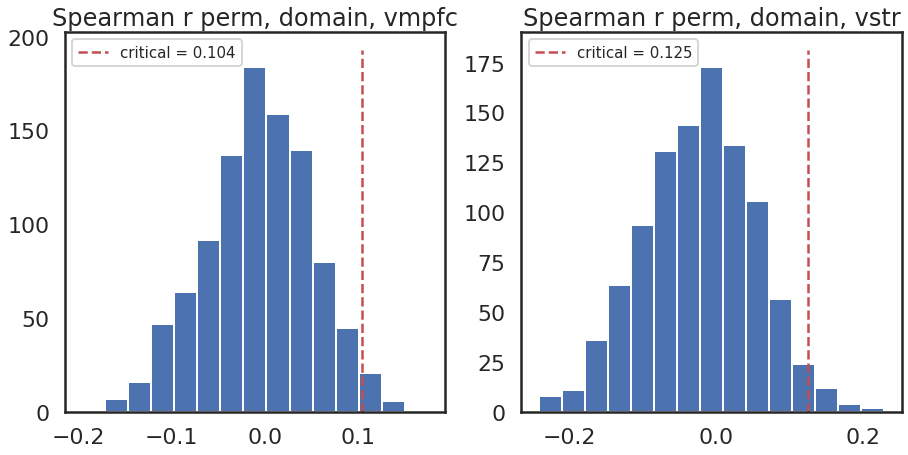

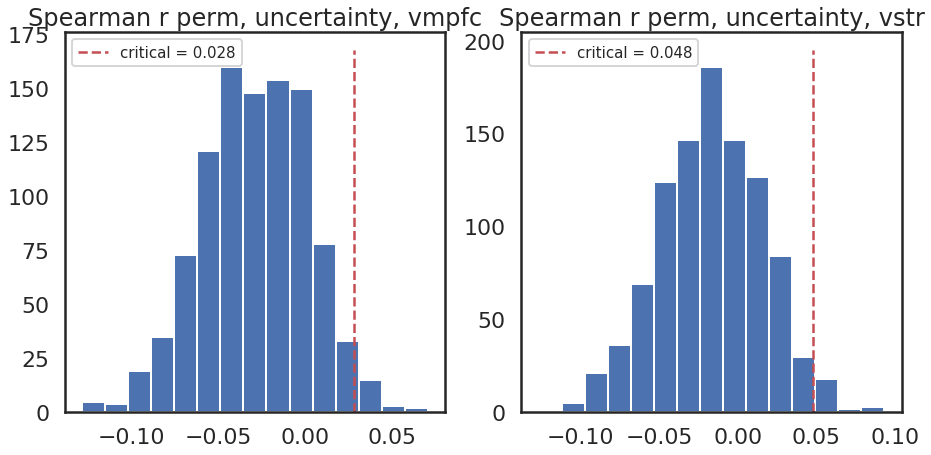

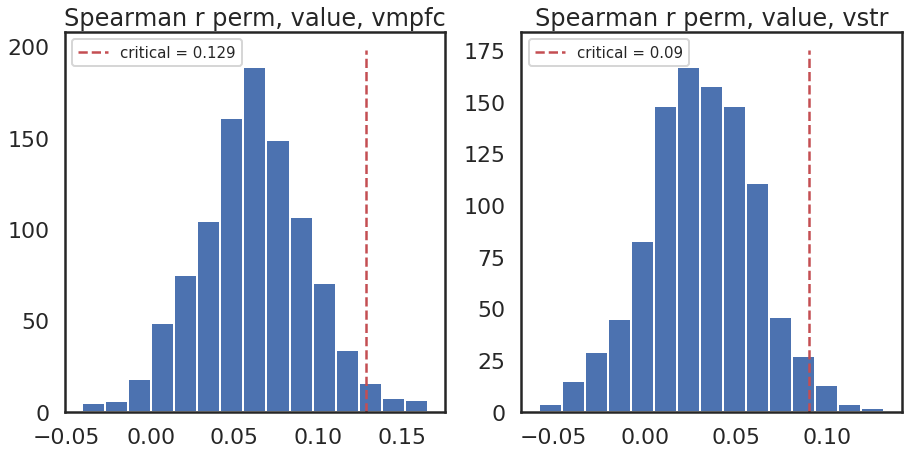

In [69]:
plot_permutation_null(spearman_r_perm)